# 엑셀 보고서 인덱싱 및 RAG 테스트

> 목표 : 엑셀 보고서 인덱싱 및 parent document / multi vector retrieval 테스트 

## 기본 설정

### 1\) 환경 설정

In [1]:
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv()

True

In [2]:
from langfuse.langchain import CallbackHandler

# 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

In [3]:
import nest_asyncio

# Jupyter 환경에서 비동기 이벤트 루프 중첩 허용
nest_asyncio.apply()

In [4]:
import matplotlib.pyplot as plt
from pprint import pprint
from langchain.schema import Document
from langchain_community.vectorstores import Chroma

In [5]:
import tiktoken

# tiktoken tokenizer 초기화
tokenizer = tiktoken.get_encoding("cl100k_base")

In [6]:
from langchain_openai import OpenAIEmbeddings

# 임베딩 모델 초기화
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

### 2\) 활용 데이터 정의

In [7]:
excel_file_path = "data/2023년 인구동태(총괄, 출생, 사망).xlsx" # 통계청 엑셀 데이터
pdf_file_path = "data/2023년 인구동태(총괄, 출생, 사망).pdf"    # 통계청 PDF 변환 데이터 (하나의 페이지에 하나의 장표가 있음)

### 3) 로컬 파일 저장소 정의

In [8]:
import pickle
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.retrievers import ParentDocumentRetriever
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage import LocalFileStore

# 로컬 파일 저장소 클래스 정의
class PickleFileStore(LocalFileStore):
    def mget(self, keys):
        return [pickle.loads(v) if v is not None else None 
                for v in super().mget(keys)]

    def mset(self, key_value_pairs):
        serialized_pairs = [(k, pickle.dumps(v)) for k, v in key_value_pairs]
        super().mset(serialized_pairs)

### 4\) 요약 생성 봇 정의

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

def generate_summary(text):
    prompt = ChatPromptTemplate.from_template(
        "Summarize the following 10-K report section in 2-3 sentences:\n\n{text}"
    )
    summary_chain = prompt | llm | StrOutputParser()
    return summary_chain.invoke({"text": text})

### 5\) 답변 생성 RAG 정의

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

system_prompt = """
You are an expert in South Korean population analysis. 

1. Please provide accurate and detailed analysis based on the provided reference materials in response to user queries.
2. For information not available in the reference materials, please clearly state "The requested information cannot be found in the provided materials."
3. Please generate your response in the same language as the user's query.
"""

human_prompt = """
Reference: \n{context}

---

User Query: \n{question}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", human_prompt)
])

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

def generate_answer(query, retriever):
    chain = {
        "context": retriever,
        "question": RunnablePassthrough()
    } | prompt | llm | StrOutputParser()
    return chain.invoke(query)

### 6\) 테스트셋

In [11]:
# 대한민국 인구 관련 테스트 질의 데이터셋
test_queries = [
    "2023년 대한민국의 출생아 수와 조출생률은 얼마인가요?",
    "2020년부터 2023년까지 합계출산율의 변화 추이를 알려주세요.",
    "2022년과 2023년의 사망자 수를 비교해서 설명해주세요.",
    "What was the total fertility rate in South Korea in 2023?",
    "How did the crude birth rate change from 2019 to 2023 in Korea?"
]

## 1. `PyPDFLoader`

> - 목표 : 표 형식이 꺠지는 데이터도 LLM이 잘 활용이 되는지 확인
> - 결과 : 표 내용 중 일부 이해 못함

### 1\) 문서 로드

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(pdf_file_path)
docs = loader.load()

print(len(docs))

docs[0] # 표 형식 깨짐

215


Document(metadata={'producer': 'macOS Version 14.6.1 (Build 23G93) Quartz PDFContext', 'creator': 'Excel', 'creationdate': "D:20250726062916Z00'00'", 'title': '2023년 인구동태(총괄, 출생, 사망)', 'author': '유선화', 'moddate': "D:20250726062916Z00'00'", 'source': 'data/2023년 인구동태(총괄, 출생, 사망).pdf', 'total_pages': 215, 'page': 0, 'page_label': '1'}, page_content='(단위: * 인구 1천 명당, ** 년)\n출생아 수\nNumber\n조출생률*\nCBR\n사망자 수\nNumber\n조사망률*\nCDR\n  \n1970 1 006 645 31.2               258 589 8.0              4.53          109.5           -1971 1 024 773 31.2               237 528 7.2              4.54          109.0           -1972  952 780 28.4               210 071 6.3              4.12          109.5           -1973  965 521 28.3               267 460 7.8              4.07          104.6           -1974  922 823 26.6               248 807 7.2              3.77          109.4           -\n-1975  874 030 24.8               270 657 7.7              3.43          112.4           -1976  796 331 22.2           

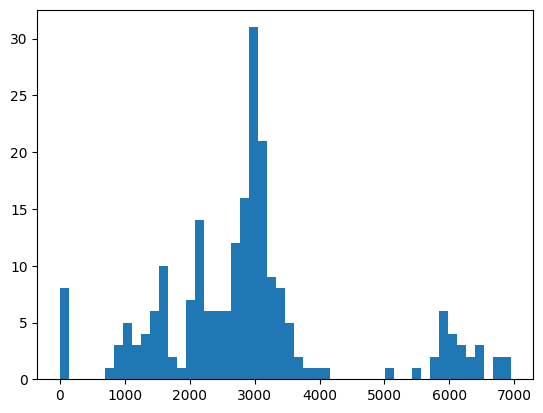

In [ ]:
# 문서별 글자 수 확인
doc_lengths = [len(doc.page_content) for doc in docs]

plt.hist(doc_lengths, bins=50)
plt.show()

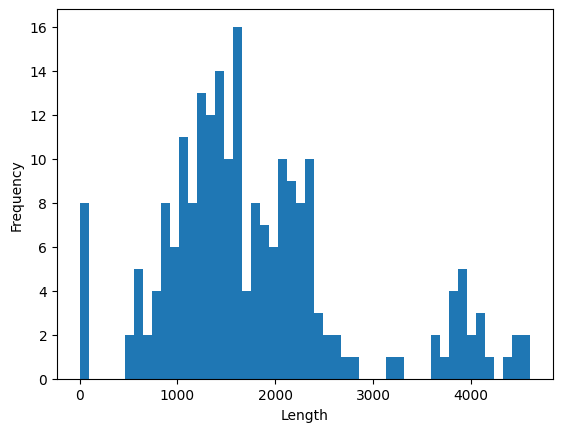

In [77]:
# 문서별 토큰 수 확인
doc_tokens = [len(tokenizer.encode(doc.page_content)) for doc in docs]
plt.hist(doc_tokens, bins=50)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

### 2\) 인덱싱

In [87]:
# 요약 문서 저장소 정의
vectorstore = Chroma(
    collection_name="population_summary_01",
    embedding_function=embeddings,
    persist_directory="./population_db"
)

# 원본 문서 저장소 정의
doc_store = PickleFileStore("./population_store_01") 

# MultiVectorRetriever 정의
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=doc_store,
    id_key="doc_id"
)

# 요약 문서 저장 리스트 초기화
summary_docs = []
original_docs = []
doc_ids = []

# 각 문서에 대한 요약 생성
for i, doc in enumerate(docs):
    doc_id = f"doc_{i}"
    summary = generate_summary(doc.page_content)
    
    # 요약 문서 생성
    summary_doc = Document(
        page_content=summary,
        metadata={"doc_id": doc_id, "title": doc.metadata["title"]}
    )
    summary_docs.append(summary_doc)
    
    # 원본 문서와 ID 저장
    original_docs.append(doc)
    doc_ids.append(doc_id)

# 벡터 스토어에 요약 문서 추가
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, original_docs)))

# 문서 개수 확인
print(f"Total documents in vectorstore: {vectorstore._collection.count()}")
all_keys = list(doc_store.yield_keys())
print(f"Total documents in store: {len(all_keys)}")

Total documents in vectorstore: 215
Total documents in store: 215


In [105]:
# 문서 검색 
retrieved_docs = retriever.invoke(test_queries[0])
print(f"Retrieved {len(retrieved_docs)} documents")

for doc in retrieved_docs:
    print(doc.page_content[:500])
    print("-" * 100)

Retrieved 4 documents
5 표. 합계출산율 : 시도, 2013~2023
 (단위: 여자 1명당 명, births per woman)
지           역
Place of residence 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013
   전국 Whole country 0.72 0.78 0.81 0.84 0.92 0.98 1.05 1.17 1.24 1.21 1.19 
서울특별시  Seoul 0.55 0.59 0.63 0.64 0.72 0.76 0.84 0.94 1.00 0.98 0.97 
부산광역시  Busan 0.66 0.72 0.73 0.75 0.83 0.90 0.98 1.10 1.14 1.09 1.05 
대구광역시  Daegu 0.70 0.76 0.78 0.81 0.93 0.99 1.07 1.19 1.22 1.17 1.13 
인천광역시  Incheon 0.69 0.75 0.78 0.83 0.94 1.01 1.01 1.14 1.22 1.21 1.2
----------------------------------------------------------------------------------------------------
2 표. 인구동태건수 : 시도, 2004~2023 Table 2. Vital statistics (number) : Cities and Provinces, 2004-2023
(단위: 출생·사망 명, 혼인·이혼 건)
지      역 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014
전     국
출    생  230 028  249 186  260 562  272 337  302 676  326 822  357 771  406 243  438 420  435 435
사    망  352 511  372 939  317 680  304 948  295 110  298 820  285 534  280 827  275 895  267

### 3\) RAG 테스트

In [100]:
response = generate_answer(test_queries[0], retriever)
print(response)

2023년 대한민국의 출생아 수는 230,028명입니다.  
조출생률(인구 1,000명당 출생아 수)은 제공된 자료에 명확히 기재되어 있지 않습니다.  

따라서 출생아 수는 정확히 알 수 있으나, 조출생률에 대한 정보는 제공된 자료에서 찾을 수 없습니다.


In [101]:
response = generate_answer(test_queries[1], retriever)
print(response)

제공된 자료에는 2020년부터 2023년까지의 합계출산율에 대한 직접적인 수치가 포함되어 있지 않습니다. 다만, 같은 기간 동안의 출생아 수 변화를 통해 합계출산율의 추이를 간접적으로 유추할 수 있습니다.

전국 출생아 수는 다음과 같습니다.  
- 2020년: 272,337명  
- 2021년: 260,562명  
- 2022년: 249,186명  
- 2023년: 230,028명  

출생아 수가 2020년부터 2023년까지 지속적으로 감소하는 추세임을 알 수 있습니다. 이는 합계출산율도 같은 기간 동안 감소했을 가능성이 높다는 점을 시사합니다.

하지만 합계출산율(여성 1명이 평생 낳을 것으로 예상되는 평균 출생아 수)의 구체적인 수치나 변화율은 제공된 자료에 포함되어 있지 않으므로, 정확한 합계출산율 변화 추이는 제공할 수 없습니다.

요약:  
- 2020년부터 2023년까지 출생아 수는 지속적으로 감소함.  
- 이에 따라 합계출산율도 감소했을 가능성이 높음.  
- 구체적인 합계출산율 수치는 자료에 포함되어 있지 않음.

따라서, 합계출산율의 정확한 변화 추이는 "제공된 자료에서 찾을 수 없습니다."


In [102]:
response = generate_answer(test_queries[2], retriever)
print(response)

제공된 자료를 바탕으로 2022년과 2023년의 사망자 수를 비교하여 설명드리겠습니다.

1. **전국 사망자 수 (성별 포함)**
- 2023년 전국 사망자 수는 총 352,511명이며, 남자가 188,921명, 여자가 163,590명입니다.
- 2022년의 정확한 전국 사망자 수는 제공된 자료에 명확히 나타나 있지 않으나, 국외 사망자 수 데이터를 통해 간접적으로 비교할 수 있습니다.

2. **국외 사망자 수 비교 (2013~2023년 월별·성별·국가별)**
- 2023년 국외 사망자 수 총계는 남자 2,655명, 여자 1,563명으로 총 4,218명입니다.
- 2022년 국외 사망자 수 총계는 남자 1,950명, 여자 1,153명으로 총 3,103명입니다.

이를 통해 국외 사망자 수는 2023년에 2022년보다 약 1,115명(약 35.9%) 증가한 것을 알 수 있습니다.

3. **전국 사망자 수 추정**
- 국외 사망자 수가 증가했음을 고려할 때, 2023년 전국 사망자 수는 2022년보다 증가했을 가능성이 높습니다.
- 다만, 2022년 전국 사망자 수에 대한 구체적인 수치는 제공된 자료에 없으므로 정확한 비교는 어렵습니다.

4. **기타 참고사항**
- 2023년 사망자 수는 성별, 연령별, 혼인상태별로 상세히 분류되어 있으며, 남성 사망자가 여성보다 다소 많습니다.
- 서울특별시 및 부산광역시 등 주요 도시별 월별 사망자 수 데이터도 제공되어 있으나, 2022년과의 직접 비교 데이터는 포함되어 있지 않습니다.

---

**요약:**  
- 2023년 국외 사망자 수는 2022년 대비 약 35.9% 증가하였으며, 전국 사망자 수 역시 증가했을 가능성이 큽니다.  
- 그러나 2022년 전국 사망자 수에 대한 구체적인 수치가 제공되지 않아 정확한 전국 사망자 수 비교는 불가능합니다.

---

**결론:**  
2022년과 2023년의 사망자 수를 직접 비교할 수 있는 전국 단위의 구체적인 사망자 수 데이터는 제공된 자료에 포함되어 있지 않습

In [103]:
response = generate_answer(test_queries[3], retriever)
print(response)

2023년 대한민국의 합계출산율은 0.72명입니다. (여자 1명당 출생아 수 기준)


In [104]:
response = generate_answer(test_queries[4], retriever)
print(response)

제공된 자료에 따르면, 한국의 조출생률(Crude Birth Rate, CBR)은 2019년부터 2023년까지 다음과 같이 변화하였습니다.

- 2019년: 5.9 (인구 1천 명당 출생아 수)
- 2020년: 5.3
- 2021년: 5.1
- 2022년: 4.9
- 2023년: 4.5

즉, 2019년 5.9에서 2023년 4.5로 지속적으로 감소하는 추세를 보였습니다. 이는 인구 1천 명당 출생아 수가 점차 줄어들고 있음을 의미합니다.


## 2. `LlamaParse`

> - 목표 : 표 형식이 깨지지 않도록 문서 로드 및 `ParentDocumentRetriever`를 활용한 검색기 정의
> - 결과 : 표 형식이 깨지지 않았으며, `ParentDocumentRetriever`를 사용하여 자식 청킹에서 표 헤더만으로도 부모 문서에 있는 값을 잘 찾는 것 같음

### 1\) 문서 로드

In [12]:
from llama_parse import LlamaParse

# 문서 파서 초기화
user_prompt = """
Please extract data in a structured format that is suitable for demographic analysis. Focus on:
1. Tables with clear headers and consistent formatting
2. Numerical data with proper alignment and units
3. Time series data (years, dates) in chronological order
4. Statistical indicators like birth rates, death rates, fertility rates, etc.
5. Geographic divisions (cities, provinces, regions) clearly labeled
6. Preserve the relationship between data points and their corresponding metadata
7. Ensure demographic terminology and classifications are accurately maintained
"""
parser = LlamaParse(
    result_type="markdown",  # 마크다운 형식으로 출력
    verbose=True,            # 상세 로그 출력
    language="ko",           # 한국어 설정
    user_prompt=user_prompt, # 사용자 정의 프롬프트
    num_workers=4
)

# 문서 파싱
documents = parser.load_data(excel_file_path)

# 파싱 결과 확인
total_pages = len(documents)
total_chars = sum(len(doc.text) for doc in documents)
total_words = sum(len(doc.text.split()) for doc in documents)

print(f"✅ 파싱 완료!")
print(f"   📊 총 페이지: {total_pages}")
print(f"   📝 총 문자 수: {total_chars:,}")
print(f"   🔤 총 단어 수: {total_words:,}")

Started parsing the file under job_id b14fdf0d-6f0f-44e2-816d-e30c82041526
✅ 파싱 완료!
   📊 총 페이지: 39
   📝 총 문자 수: 2,193,175
   🔤 총 단어 수: 291,828


In [13]:
documents[0].get_content()

'# 1표\n\n| 1 표. 인구동태건수 및 동태율 : 전국, 1970∼2023             |                     |                |                  |                |                                       |                                    |                                       | Table 1. Vital statistics : Whole country, 1970-2023 |            |              |                   |                |                  |                |                                           |\n| --------------------------------------------- | ------------------- | -------------- | ---------------- | -------------- | ------------------------------------- | ---------------------------------- | ------------------------------------- | ---------------------------------------------------- | ---------- | ------------ | ----------------- | -------------- | ---------------- | -------------- | ----------------------------------------- |\n|                                               |                     |                |                 

In [15]:
from IPython.display import Markdown, display
display(Markdown(documents[1].get_content()))

# 2표

| 2 표. 인구동태건수 : 시도, 2004\~2023      |   |         |         |         |         |         |         |         |         |         |                        | Table 2. Vital statistics (number) : Cities and Provinces, 2004-2023 |         |         |         |         |         |         |         |         |         |   |                       |
| --------------------------------- | - | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ---------------------- | -------------------------------------------------------------------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | - | --------------------- |
|                                   |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   |                       |
|                                   |   |         |         |         |         |         |         |         |         |         | (단위: 출생·사망 명, 혼인·이혼 건) |                                                                      |         |         |         |         |         |         |         |         |         |   | (Unit: persons, case) |
| 지 역                               |   | 2023    | 2022    | 2021    | 2020    | 2019    | 2018    | 2017    | 2016    | 2015    | 2014                   | 2013                                                                 | 2012    | 2011    | 2010    | 2009    | 2008    | 2007    | 2006    | 2005    | 2004    |   | Place of residence    |
|                                   |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   |                       |
| 전 국                               |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Whole country         |
| 출 생                               |   | 230 028 | 249 186 | 260 562 | 272 337 | 302 676 | 326 822 | 357 771 | 406 243 | 438 420 | 435 435                | 436 455                                                              | 484 550 | 471 265 | 470 171 | 444 849 | 465 892 | 496 822 | 451 759 | 438 707 | 476 958 |   | Live births           |
| 사 망                               |   | 352 511 | 372 939 | 317 680 | 304 948 | 295 110 | 298 820 | 285 534 | 280 827 | 275 895 | 267 692                | 266 257                                                              | 267 221 | 257 396 | 255 405 | 246 942 | 246 113 | 246 482 | 244 162 | 245 874 | 246 220 |   | Deaths                |
| 혼 인                               |   | 193 657 | 191 690 | 192 507 | 213 502 | 239 159 | 257 622 | 264 455 | 281 635 | 302 828 | 305 507                | 322 807                                                              | 327 073 | 329 087 | 326 104 | 309 759 | 327 715 | 343 559 | 330 634 | 314 304 | 308 598 |   | Marriages             |
| 이 혼                               |   | 92 394  | 93 232  | 101 673 | 106 500 | 110 831 | 108 684 | 106 032 | 107 328 | 109 153 | 115 510                | 115 292                                                              | 114 316 | 114 284 | 116 858 | 123 999 | 116 535 | 124 072 | 124 524 | 128 035 | 138 932 |   | Divorces              |
| 서울특별시                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Seoul                 |
| 출 생                               |   | 39 456  | 42 602  | 45 531  | 47 445  | 53 673  | 58 074  | 65 389  | 75 536  | 83 005  | 83 711                 | 84 066                                                               | 93 914  | 91 526  | 93 266  | 89 594  | 94 736  | 101 249 | 93 922  | 90 468  | 99 828  |   | Live births           |
| 사 망                               |   | 51 446  | 55 296  | 48 798  | 45 522  | 43 829  | 45 219  | 42 932  | 43 540  | 43 053  | 42 153                 | 42 063                                                               | 41 514  | 40 320  | 40 130  | 38 790  | 38 298  | 39 016  | 38 519  | 38 751  | 38 274  |   | Deaths                |
| 혼 인                               |   | 36 324  | 35 752  | 37 012  | 44 746  | 48 261  | 52 005  | 53 776  | 57 643  | 64 193  | 64 823                 | 68 819                                                               | 71 695  | 71 519  | 70 466  | 68 841  | 71 753  | 76 399  | 73 924  | 71 286  | 71 553  |   | Marriages             |
| 이 혼                               |   | 12 397  | 13 174  | 14 967  | 16 282  | 16 972  | 16 940  | 17 083  | 17 777  | 18 176  | 19 477                 | 20 126                                                               | 20 177  | 20 617  | 21 768  | 23 920  | 23 319  | 24 615  | 24 354  | 25 300  | 26 994  |   | Divorces              |
| 부산광역시                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Busan                 |
| 출 생                               |   | 12 866  | 14 134  | 14 446  | 15 058  | 17 049  | 19 152  | 21 480  | 24 906  | 26 645  | 26 190                 | 25 831                                                               | 28 673  | 27 759  | 27 415  | 25 110  | 26 670  | 28 426  | 25 881  | 25 681  | 28 231  |   | Live births           |
| 사 망                               |   | 26 303  | 27 713  | 23 531  | 22 950  | 22 260  | 22 570  | 21 434  | 21 074  | 20 820  | 20 230                 | 20 096                                                               | 20 534  | 19 643  | 19 708  | 18 954  | 19 385  | 19 170  | 18 983  | 18 854  | 18 722  |   | Deaths                |
| 혼 인                               |   | 10 303  | 10 618  | 11 081  | 12 128  | 13 780  | 14 781  | 15 677  | 17 113  | 18 553  | 18 927                 | 20 734                                                               | 20 362  | 20 224  | 20 195  | 18 614  | 20 149  | 21 484  | 20 017  | 18 973  | 19 898  |   | Marriages             |
| 이 혼                               |   | 5 452   | 5 523   | 6 248   | 6 497   | 6 787   | 6 678   | 6 651   | 6 859   | 6 649   | 7 345                  | 7 444                                                                | 7 501   | 7 514   | 7 645   | 8 550   | 7 908   | 8 677   | 8 953   | 9 905   | 11 334  |   | Divorces              |
| 대구광역시                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Daegu                 |
| 출 생                               |   | 9 410   | 10 134  | 10 661  | 11 193  | 13 233  | 14 400  | 15 946  | 18 298  | 19 438  | 19 361                 | 19 340                                                               | 21 472  | 20 758  | 20 557  | 19 399  | 20 562  | 22 295  | 20 360  | 20 804  | 23 259  |   | Live births           |
| 사 망                               |   | 16 556  | 17 592  | 14 560  | 14 460  | 13 752  | 14 070  | 13 629  | 13 502  | 13 081  | 12 642                 | 12 531                                                               | 12 352  | 12 355  | 12 054  | 11 741  | 11 605  | 11 282  | 11 359  | 11 507  | 11 848  |   | Deaths                |
| 혼 인                               |   | 8 150   | 7 497   | 7 287   | 8 340   | 9 880   | 10 967  | 11 392  | 12 216  | 12 545  | 12 552                 | 13 601                                                               | 13 642  | 13 813  | 13 479  | 12 844  | 13 743  | 14 655  | 13 892  | 13 152  | 13 792  |   | Marriages             |
| 이 혼                               |   | 3 931   | 3 675   | 4 111   | 4 345   | 4 655   | 4 530   | 4 380   | 4 383   | 4 497   | 4 794                  | 4 796                                                                | 4 947   | 4 658   | 5 107   | 5 361   | 5 005   | 5 330   | 5 490   | 5 916   | 6 635   |   | Divorces              |
| 인천광역시                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Incheon               |
| 출 생                               |   | 13 659  | 14 464  | 14 947  | 16 040  | 18 522  | 20 087  | 20 445  | 23 609  | 25 491  | 25 786                 | 25 560                                                               | 27 781  | 26 118  | 25 752  | 24 379  | 25 365  | 26 712  | 23 711  | 23 026  | 25 092  |   | Live births           |
| 사 망                               |   | 18 242  | 18 957  | 16 493  | 15 689  | 15 131  | 15 316  | 14 290  | 14 119  | 13 452  | 13 409                 | 13 039                                                               | 12 881  | 12 504  | 12 087  | 11 662  | 11 366  | 11 376  | 11 068  | 11 144  | 11 042  |   | Deaths                |
| 혼 인                               |   | 11 621  | 10 849  | 10 881  | 11 574  | 13 401  | 14 850  | 15 235  | 16 092  | 17 118  | 17 251                 | 18 010                                                               | 18 079  | 18 013  | 17 407  | 16 643  | 18 108  | 18 227  | 17 261  | 16 515  | 15 900  |   | Marriages             |
| 이 혼                               |   | 6 243   | 6 045   | 6 740   | 6 931   | 7 176   | 7 011   | 6 988   | 7 097   | 7 116   | 7 417                  | 7 253                                                                | 7 306   | 6 840   | 7 354   | 7 880   | 7 414   | 7 854   | 8 132   | 8 646   | 9 546   |   | Divorces              |
| 광주광역시                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Gwangju               |
| 출 생                               |   | 6 172   | 7 446   | 7 956   | 7 318   | 8 364   | 9 105   | 10 120  | 11 580  | 12 441  | 12 729                 | 12 729                                                               | 14 392  | 13 916  | 13 979  | 13 101  | 13 890  | 14 810  | 13 679  | 13 327  | 14 729  |   | Live births           |
| 사 망                               |   | 8 866   | 9 350   | 7 981   | 7 785   | 7 635   | 7 781   | 7 560   | 7 247   | 7 443   | 6 935                  | 6 891                                                                | 6 874   | 6 593   | 6 532   | 6 179   | 6 132   | 6 107   | 5 772   | 5 939   | 6 042   |   | Deaths                |
| 혼 인                               |   | 5 169   | 4 902   | 4 901   | 5 560   | 6 297   | 6 632   | 7 141   | 7 468   | 7 945   | 8 213                  | 8 820                                                                | 8 596   | 8 946   | 8 566   | 8 088   | 8 472   | 8 858   | 8 487   | 7 827   | 8 012   |   | Marriages             |
| 이 혼                               |   | 2 399   | 2 360   | 2 572   | 2 604   | 2 915   | 2 887   | 2 694   | 2 817   | 2 842   | 3 051                  | 2 924                                                                | 2 923   | 2 857   | 3 002   | 3 076   | 2 836   | 2 925   | 2 974   | 3 127   | 3 558   |   | Divorces              |
| 대전광역시                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Daejeon               |
| 출 생                               |   | 7 194   | 7 677   | 7 414   | 7 481   | 8 410   | 9 337   | 10 851  | 12 436  | 13 774  | 13 962                 | 14 099                                                               | 15 279  | 14 808  | 14 314  | 13 915  | 14 856  | 15 780  | 14 489  | 13 950  | 15 024  |   | Live births           |
| 사 망                               |   | 8 677   | 9 302   | 7 889   | 7 572   | 7 502   | 7 403   | 7 029   | 6 958   | 6 961   | 6 564                  | 6 634                                                                | 6 580   | 6 336   | 6 313   | 5 949   | 6 105   | 5 991   | 5 952   | 5 779   | 5 951   |   | Deaths                |
| 혼 인                               |   | 5 212   | 5 662   | 5 419   | 5 976   | 6 602   | 7 377   | 7 697   | 8 325   | 8 805   | 9 118                  | 9 621                                                                | 9 745   | 9 726   | 9 351   | 8 885   | 9 499   | 9 684   | 9 502   | 9 035   | 8 857   |   | Marriages             |
| 이 혼                               |   | 2 471   | 2 492   | 2 754   | 3 009   | 3 097   | 3 008   | 2 855   | 2 890   | 2 999   | 3 221                  | 3 003                                                                | 2 938   | 3 067   | 3 189   | 3 433   | 3 236   | 3 449   | 3 287   | 3 328   | 3 942   |   | Divorces              |
| 울산광역시                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Ulsan                 |
| 출 생                               |   | 5 082   | 5 399   | 6 127   | 6 617   | 7 539   | 8 149   | 9 381   | 10 910  | 11 732  | 11 556                 | 11 330                                                               | 12 160  | 11 542  | 11 432  | 11 033  | 11 365  | 11 955  | 10 740  | 10 469  | 11 151  |   | Live births           |
| 사 망                               |   | 6 076   | 6 369   | 5 493   | 5 302   | 5 268   | 5 349   | 4 886   | 4 947   | 4 915   | 4 695                  | 4 871                                                                | 4 567   | 4 462   | 4 328   | 4 318   | 4 172   | 4 131   | 4 104   | 4 108   | 3 969   |   | Deaths                |
| 혼 인                               |   | 4 274   | 4 013   | 4 077   | 4 737   | 5 442   | 5 894   | 6 331   | 7 006   | 7 483   | 7 674                  | 7 998                                                                | 7 887   | 7 768   | 7 660   | 7 267   | 7 837   | 7 563   | 7 493   | 6 939   | 6 647   |   | Marriages             |
| 이 혼                               |   | 2 060   | 2 165   | 2 425   | 2 460   | 2 534   | 2 658   | 2 519   | 2 520   | 2 406   | 2 731                  | 2 578                                                                | 2 590   | 2 380   | 2 597   | 2 591   | 2 295   | 2 581   | 2 825   | 2 780   | 3 024   |   | Divorces              |
| 세종특별자치시                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Sejong                |
| 출 생                               |   | 2 761   | 3 209   | 3 570   | 3 468   | 3 819   | 3 703   | 3 504   | 3 297   | 2 708   | 1 344                  | 1 111                                                                | 1 054   | -       | -       | -       | -       | -       | -       | -       | -       |   | Live births           |
| 사 망                               |   | 1 595   | 1 678   | 1 354   | 1 317   | 1 221   | 1 259   | 1 159   | 1 065   | 979     | 853                    | 812                                                                  | 820     | -       | -       | -       | -       | -       | -       | -       | -       |   | Deaths                |
| 혼 인                               |   | 1 705   | 1 664   | 1 627   | 1 854   | 2 039   | 2 038   | 1 728   | 1 612   | 1 498   | 920                    | 743                                                                  | 634     | -       | -       | -       | -       | -       | -       | -       | -       |   | Marriages             |
| 이 혼                               |   | 569     | 546     | 624     | 601     | 606     | 485     | 465     | 343     | 324     | 280                    | 240                                                                  | 223     | -       | -       | -       | -       | -       | -       | -       | -       |   | Divorces              |
|                                   |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   |                       |
| 1) 본표의 혼인과 이혼건수는 남편의 주소지를 기준으로 집계 |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   |                       |
| 2 표. 인구동태건수 : 시도, 2004\~2023      |   |         |         |         |         |         |         |         |         |         |                        | Table 2. Vital statistics (number) : Cities and Provinces, 2004-2023 |         |         |         |         |         |         |         |         |         |   |                       |
|                                   |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   |                       |
|                                   |   |         |         |         |         |         |         |         |         |         | -계 속-                  |                                                                      |         |         |         |         |         |         |         |         |         |   | -Cont'd-              |
| 지 역                               |   | 2023    | 2022    | 2021    | 2020    | 2019    | 2018    | 2017    | 2016    | 2015    | 2014                   | 2013                                                                 | 2012    | 2011    | 2010    | 2009    | 2008    | 2007    | 2006    | 2005    | 2004    |   | Place of residence    |
|                                   |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   |                       |
| 경 기 도                             |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Gyeonggi              |
| 출 생                               |   | 68 817  | 75 323  | 76 139  | 77 737  | 83 198  | 88 175  | 94 088  | 105 643 | 113 495 | 112 169                | 112 129                                                              | 124 746 | 122 027 | 121 753 | 113 692 | 119 397 | 126 648 | 115 111 | 109 533 | 117 812 |   | Live births           |
| 사 망                               |   | 74 949  | 79 010  | 67 399  | 62 794  | 60 568  | 60 050  | 56 852  | 55 215  | 53 005  | 51 425                 | 50 959                                                               | 50 830  | 48 394  | 47 687  | 45 132  | 44 168  | 43 865  | 43 195  | 42 991  | 42 266  |   | Deaths                |
| 혼 인                               |   | 54 221  | 54 178  | 54 658  | 57 814  | 62 356  | 66 877  | 66 429  | 70 052  | 73 950  | 74 306                 | 77 649                                                               | 79 449  | 79 137  | 78 471  | 73 403  | 78 004  | 81 248  | 77 231  | 72 431  | 70 236  |   | Marriages             |
| 이 혼                               |   | 24 833  | 24 864  | 27 256  | 27 983  | 28 453  | 27 884  | 26 924  | 26 723  | 27 688  | 28 892                 | 28 733                                                               | 28 452  | 28 444  | 27 810  | 29 807  | 28 379  | 29 964  | 30 003  | 30 358  | 31 608  |   | Divorces              |
| 강원특별자치도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Gangwon               |
| 출 생                               |   | 6 688   | 7 278   | 7 357   | 7 835   | 8 283   | 8 351   | 8 958   | 10 058  | 10 929  | 10 662                 | 10 980                                                               | 12 426  | 12 408  | 12 477  | 12 112  | 12 373  | 13 690  | 12 455  | 12 657  | 13 776  |   | Live births           |
| 사 망                               |   | 14 224  | 15 086  | 12 749  | 12 182  | 11 906  | 11 976  | 11 545  | 11 437  | 11 301  | 11 004                 | 10 756                                                               | 11 030  | 10 521  | 10 729  | 10 415  | 10 506  | 10 401  | 10 490  | 10 573  | 10 651  |   | Deaths                |
| 혼 인                               |   | 5 494   | 5 572   | 5 622   | 5 868   | 6 762   | 6 994   | 7 295   | 7 468   | 7 876   | 7 785                  | 7 946                                                                | 8 225   | 8 338   | 8 365   | 8 081   | 8 517   | 8 930   | 8 731   | 8 496   | 8 235   |   | Marriages             |
| 이 혼                               |   | 2 961   | 3 117   | 3 161   | 3 358   | 3 624   | 3 418   | 3 263   | 3 482   | 3 484   | 3 630                  | 3 725                                                                | 3 550   | 3 562   | 3 579   | 3 742   | 3 394   | 3 818   | 3 985   | 4 105   | 4 322   |   | Divorces              |
| 충 청 북 도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Chungbuk              |
| 출 생                               |   | 7 580   | 7 452   | 8 190   | 8 607   | 9 333   | 10 586  | 11 394  | 12 742  | 13 563  | 13 366                 | 13 658                                                               | 15 139  | 14 804  | 14 670  | 13 903  | 14 064  | 15 002  | 13 366  | 13 164  | 14 331  |   | Live births           |
| 사 망                               |   | 13 463  | 14 108  | 11 941  | 11 594  | 11 363  | 11 334  | 11 104  | 10 787  | 10 638  | 10 174                 | 10 371                                                               | 10 478  | 10 176  | 9 825   | 9 985   | 9 717   | 9 690   | 9 555   | 9 727   | 9 605   |   | Deaths                |
| 혼 인                               |   | 6 212   | 6 185   | 5 882   | 6 682   | 7 239   | 7 827   | 7 990   | 8 334   | 8 872   | 8 774                  | 9 307                                                                | 9 275   | 9 542   | 9 171   | 8 666   | 9 512   | 9 834   | 9 291   | 8 390   | 8 534   |   | Marriages             |
| 이 혼                               |   | 3 255   | 3 271   | 3 256   | 3 492   | 3 699   | 3 543   | 3 461   | 3 446   | 3 486   | 3 671                  | 3 732                                                                | 3 424   | 3 675   | 3 554   | 3 738   | 3 354   | 3 558   | 3 438   | 3 469   | 3 839   |   | Divorces              |
| 충 청 남 도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Chungnam              |
| 출 생                               |   | 9 436   | 10 221  | 10 984  | 11 950  | 13 228  | 14 380  | 15 670  | 17 302  | 18 604  | 18 200                 | 18 628                                                               | 20 448  | 20 398  | 20 242  | 19 257  | 19 749  | 20 630  | 18 625  | 17 521  | 18 640  |   | Live births           |
| 사 망                               |   | 18 781  | 19 719  | 16 326  | 16 022  | 15 596  | 15 802  | 15 321  | 14 600  | 14 469  | 14 149                 | 13 854                                                               | 13 994  | 14 025  | 14 014  | 13 555  | 13 592  | 13 953  | 13 617  | 14 018  | 14 087  |   | Deaths                |
| 혼 인                               |   | 8 264   | 8 017   | 8 016   | 8 493   | 9 826   | 10 970  | 10 961  | 11 792  | 12 331  | 12 040                 | 12 482                                                               | 12 849  | 13 216  | 13 185  | 12 708  | 13 354  | 13 766  | 13 373  | 12 107  | 11 418  |   | Marriages             |
| 이 혼                               |   | 4 429   | 4 527   | 4 798   | 5 003   | 5 202   | 4 842   | 4 835   | 4 682   | 4 724   | 4 915                  | 4 820                                                                | 4 685   | 4 819   | 4 756   | 5 178   | 4 472   | 4 703   | 4 647   | 4 594   | 5 148   |   | Divorces              |
| 전 라 북 도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Jeonbuk               |
| 출 생                               |   | 6 622   | 7 032   | 7 475   | 8 165   | 8 971   | 10 001  | 11 348  | 12 698  | 14 087  | 14 231                 | 14 555                                                               | 16 238  | 16 175  | 16 100  | 15 233  | 15 878  | 17 228  | 15 571  | 15 745  | 17 257  |   | Live births           |
| 사 망                               |   | 17 201  | 17 852  | 15 049  | 14 691  | 14 525  | 14 552  | 14 295  | 14 062  | 13 721  | 13 563                 | 13 492                                                               | 13 700  | 13 126  | 13 188  | 12 921  | 13 241  | 13 380  | 13 347  | 13 456  | 13 574  |   | Deaths                |
| 혼 인                               |   | 5 483   | 5 394   | 5 325   | 6 053   | 7 005   | 7 219   | 7 817   | 8 216   | 9 060   | 9 211                  | 9 823                                                                | 10 022  | 10 353  | 10 525  | 9 605   | 10 399  | 10 864  | 10 429  | 10 196  | 10 111  |   | Marriages             |
| 이 혼                               |   | 3 420   | 3 377   | 3 748   | 3 763   | 4 007   | 3 934   | 3 698   | 3 979   | 3 755   | 4 091                  | 4 144                                                                | 3 856   | 4 176   | 3 910   | 4 285   | 3 784   | 4 417   | 4 448   | 4 471   | 5 086   |   | Divorces              |
| 전 라 남 도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Jeonnam               |
| 출 생                               |   | 7 828   | 7 888   | 8 430   | 9 738   | 10 832  | 11 238  | 12 354  | 13 980  | 15 061  | 14 817                 | 15 401                                                               | 16 990  | 16 612  | 16 654  | 15 995  | 16 363  | 17 844  | 15 905  | 15 818  | 17 256  |   | Live births           |
| 사 망                               |   | 19 786  | 20 876  | 17 568  | 17 436  | 16 787  | 17 219  | 16 848  | 16 561  | 16 543  | 16 053                 | 16 332                                                               | 16 766  | 16 090  | 16 042  | 15 734  | 16 018  | 16 030  | 16 253  | 16 329  | 17 141  |   | Deaths                |
| 혼 인                               |   | 6 157   | 6 181   | 6 201   | 6 365   | 7 413   | 7 587   | 8 049   | 8 554   | 9 275   | 9 357                  | 9 995                                                                | 9 827   | 10 266  | 10 461  | 10 051  | 10 480  | 10 854  | 10 507  | 9 984   | 9 675   |   | Marriages             |
| 이 혼                               |   | 3 517   | 3 565   | 3 776   | 3 907   | 4 130   | 4 170   | 4 008   | 3 965   | 4 033   | 4 135                  | 4 096                                                                | 4 011   | 4 138   | 4 326   | 4 290   | 4 021   | 4 240   | 4 423   | 4 394   | 4 915   |   | Divorces              |
| 경 상 북 도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Gyeongbuk             |
| 출 생                               |   | 10 186  | 11 311  | 12 045  | 12 873  | 14 472  | 16 079  | 17 957  | 20 616  | 22 310  | 22 062                 | 22 206                                                               | 24 635  | 24 250  | 23 700  | 22 373  | 23 538  | 25 062  | 22 567  | 22 339  | 23 553  |   | Live births           |
| 사 망                               |   | 25 283  | 27 840  | 22 928  | 22 799  | 21 703  | 22 289  | 21 278  | 20 978  | 20 862  | 20 304                 | 20 245                                                               | 20 644  | 20 237  | 20 249  | 19 627  | 19 654  | 19 975  | 19 943  | 20 310  | 20 684  |   | Deaths                |
| 혼 인                               |   | 8 128   | 8 180   | 8 163   | 9 046   | 10 637  | 11 687  | 12 190  | 13 363  | 14 273  | 14 183                 | 15 421                                                               | 15 383  | 15 942  | 15 592  | 14 499  | 15 634  | 16 623  | 16 178  | 14 639  | 14 000  |   | Marriages             |
| 이 혼                               |   | 4 870   | 4 911   | 5 097   | 5 553   | 5 635   | 5 620   | 5 505   | 5 375   | 5 348   | 5 503                  | 5 410                                                                | 5 562   | 5 322   | 5 476   | 5 523   | 5 287   | 5 571   | 5 604   | 5 828   | 6 376   |   | Divorces              |
| 경 상 남 도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Gyeongnam             |
| 출 생                               |   | 13 049  | 14 017  | 15 562  | 16 823  | 19 250  | 21 224  | 23 849  | 27 138  | 29 537  | 29 763                 | 29 504                                                               | 33 211  | 32 536  | 32 203  | 30 320  | 31 493  | 33 313  | 29 524  | 28 471  | 30 922  |   | Live births           |
| 사 망                               |   | 26 386  | 27 385  | 23 392  | 22 881  | 22 105  | 22 719  | 21 634  | 21 193  | 21 313  | 20 239                 | 19 994                                                               | 20 419  | 19 593  | 19 502  | 19 157  | 19 341  | 19 184  | 18 982  | 19 420  | 19 481  |   | Deaths                |
| 혼 인                               |   | 10 232  | 10 504  | 10 531  | 11 900  | 13 613  | 14 996  | 15 978  | 17 580  | 18 671  | 19 056                 | 20 291                                                               | 20 140  | 20 769  | 21 170  | 19 494  | 20 497  | 21 555  | 20 789  | 18 664  | 18 375  |   | Marriages             |
| 이 혼                               |   | 6 471   | 6 530   | 7 034   | 7 368   | 7 827   | 7 575   | 7 355   | 7 486   | 7 368   | 7 602                  | 7 547                                                                | 7 427   | 7 207   | 7 503   | 7 476   | 6 981   | 7 493   | 7 603   | 7 844   | 8 547   |   | Divorces              |
| 제주특별자치도                           |   |         |         |         |         |         |         |         |         |         |                        |                                                                      |         |         |         |         |         |         |         |         |         |   | Jeju                  |
| 출 생                               |   | 3 222   | 3 599   | 3 728   | 3 989   | 4 500   | 4 781   | 5 037   | 5 494   | 5 600   | 5 526                  | 5 328                                                                | 5 992   | 5 628   | 5 657   | 5 433   | 5 593   | 6 178   | 5 853   | 5 734   | 6 097   |   | Live births           |
| 사 망                               |   | 4 677   | 4 806   | 4 229   | 3 952   | 3 959   | 3 912   | 3 738   | 3 542   | 3 339   | 3 300                  | 3 317                                                                | 3 238   | 3 021   | 3 017   | 2 823   | 2 813   | 2 931   | 3 023   | 2 968   | 2 883   |   | Deaths                |
| 혼 인                               |   | 2 614   | 2 718   | 2 661   | 2 981   | 3 358   | 3 638   | 3 654   | 3 705   | 3 676   | 3 593                  | 3 638                                                                | 3 482   | 3 582   | 3 515   | 3 279   | 3 445   | 3 495   | 3 576   | 3 382   | 3 325   |   | Marriages             |
| 이 혼                               |   | 1 493   | 1 564   | 1 490   | 1 744   | 1 716   | 1 607   | 1 530   | 1 552   | 1 447   | 1 530                  | 1 440                                                                | 1 426   | 1 395   | 1 466   | 1 469   | 1 238   | 1 561   | 1 613   | 1 663   | 1 777   |   | Divorces              |


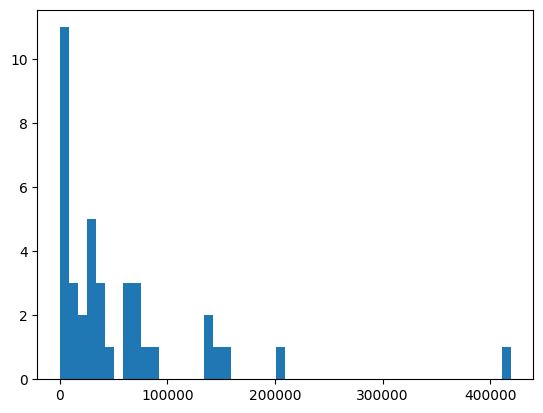

In [18]:
# 문서별 글자 수 확인
doc_lengths = [len(doc.text) for doc in documents]

plt.hist(doc_lengths, bins=50)
plt.show()

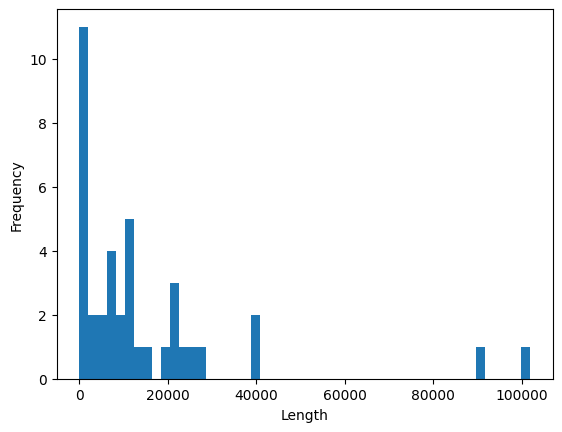

In [19]:
# 문서별 토큰 수 확인
doc_tokens = [len(tokenizer.encode(doc.text)) for doc in documents]
plt.hist(doc_tokens, bins=50)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

### 2\) 인덱싱

In [25]:
# 자식 문서용 텍스트 스플리터 (검색용 작은 청크)
child_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,
    chunk_overlap=100,
    separators=["\n\n", "\n", "|", ""]
)

# 부모 문서 저장소 정의
store = PickleFileStore("./population_store_02")

# 벡터 스토어 초기화
vectorstore = Chroma(
    collection_name="population_sections_01",
    embedding_function=embeddings,
    persist_directory="./population_db"
)

# ParentDocumentRetriever 설정
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

# 문서 추가
retriever.add_documents([Document(page_content=doc.text) for doc in documents])

In [26]:
# 검색기 테스트
retrieved_docs = retriever.invoke(test_queries[0])
print(f"Retrieved {len(retrieved_docs)} documents")

for doc in retrieved_docs:
    print(doc.page_content[:500])
    print("-" * 100)

Retrieved 3 documents
# 부록 2_출생

| 2. 국가, 성ㆍ발생월별 국외 출생 2013\~2023              |             |          |       |        |         |        |         |        |         |        |         |        |         |         | 2. Live births by sex and month of occurrence : abroad, 2013\~2023 |        |         |        |         |        |         |        |          |        |          |        |          |        |                        |
| ------------------------------------------- | ----------- | -------- | ----- | --
----------------------------------------------------------------------------------------------------
# 1표

| 1 표. 인구동태건수 및 동태율 : 전국, 1970∼2023             |                     |                |                  |                |                                       |                                    |                                       | Table 1. Vital statistics : Whole country, 1970-2023 |            |              |                   |                |         

### 3\) RAG 테스트

In [27]:
response = generate_answer(test_queries[0], retriever)
print(response)

2023년 대한민국의 출생아 수는 230,028명이며, 조출생률은 4.5명(인구 1천 명당)입니다.


In [28]:
response = generate_answer(test_queries[1], retriever)
print(response)

2020년부터 2023년까지 대한민국의 합계출산율 변화 추이는 다음과 같습니다.

- 2020년: 0.84
- 2021년: 0.81
- 2022년: 0.78
- 2023년: 0.72

요약하면, 2020년부터 2023년까지 합계출산율은 지속적으로 감소하는 추세를 보이고 있습니다. 2020년 0.84에서 2023년 0.72로 약간의 하락이 있었습니다.


In [29]:
response = generate_answer(test_queries[2], retriever)
print(response)

2022년과 2023년의 사망자 수를 비교하면 다음과 같습니다.

- 전국 사망자 수:
  - 2022년: 372,939명
  - 2023년: 352,511명
  - 차이: 2023년이 2022년보다 20,428명 감소

- 주요 광역시별 사망자 수 변화:
  - 서울특별시: 2022년 55,296명 → 2023년 51,446명 (3,850명 감소)
  - 부산광역시: 2022년 27,713명 → 2023년 26,303명 (1,410명 감소)
  - 대구광역시: 2022년 17,592명 → 2023년 16,556명 (1,036명 감소)
  - 인천광역시: 2022년 18,957명 → 2023년 18,242명 (715명 감소)
  - 광주광역시: 2022년 9,350명 → 2023년 8,866명 (484명 감소)
  - 대전광역시: 2022년 9,302명 → 2023년 8,677명 (625명 감소)
  - 울산광역시: 2022년 6,369명 → 2023년 6,076명 (293명 감소)
  - 세종특별자치시: 2022년 1,678명 → 2023년 1,595명 (83명 감소)

- 경기도 사망자 수:
  - 2022년: 79,010명
  - 2023년: 74,949명
  - 차이: 4,061명 감소

전반적으로 2023년의 사망자 수는 2022년에 비해 전국적으로 약 20,000명 이상 감소하였으며, 서울, 부산, 대구, 인천 등 주요 도시에서도 사망자 수가 모두 감소한 것으로 나타났습니다. 이는 2023년에 사망률이 다소 낮아졌음을 의미합니다.

요약하면, 2023년은 2022년에 비해 사망자 수가 전국적으로 감소한 해입니다.


In [30]:
response = generate_answer(test_queries[3], retriever)
print(response)

2023년 대한민국의 합계출산율은 0.72명입니다.


In [31]:
response = generate_answer(test_queries[4], retriever)
print(response)

제공된 자료에는 2019년부터 2023년까지의 한국의 조출생률(crude birth rate)에 대한 직접적인 수치가 명시되어 있지 않습니다. 다만, 출생 건수와 인구 관련 통계가 포함되어 있어 이를 바탕으로 조출생률 변화를 유추할 수 있습니다.

- 2019년 출생자 수: 302,676명
- 2020년 출생자 수: 272,337명
- 2021년 출생자 수: 260,562명
- 2022년 출생자 수: 249,186명
- 2023년 출생자 수: 230,028명

출생자 수는 2019년 이후 지속적으로 감소하는 추세를 보이고 있습니다. 조출생률은 인구 1,000명당 출생아 수를 의미하므로, 인구 규모 변동에 따라 다소 차이가 있을 수 있으나, 출생자 수 감소는 조출생률 하락으로 이어졌을 가능성이 큽니다.

따라서 2019년부터 2023년까지 한국의 조출생률은 전반적으로 감소한 것으로 분석됩니다.

요약:
- 2019년부터 2023년까지 출생자 수가 꾸준히 감소
- 이에 따라 조출생률도 감소 추세로 추정

참고: 정확한 조출생률 수치는 제공된 자료에 포함되어 있지 않습니다.

필요시 인구 규모 자료와 함께 조출생률을 별도로 계산해야 합니다.
